# Congress Clustering

Create a dataset from the ProPublica JSON API response.

In [1]:
import pickle
import pandas as pd
from sklearn.preprocessing import OneHotEncoder
from datetime import datetime

with open('representatives.pkl', 'rb') as f: 
    reps_orig = pd.DataFrame(pickle.load(f))
    
with open('senators.pkl', 'rb') as f: 
    sens_orig = pd.DataFrame(pickle.load(f))
    

fields = ['id', 'in_office', 'date_of_birth', 'gender', 'party', 'dw_nominate', 'seniority', 'total_votes',
          'missed_votes', 'total_present', 'missed_votes_pct', 'votes_with_party_pct', 'votes_against_party_pct']

reps = reps_orig[fields].copy()
sens = sens_orig[fields].copy()

reps['chamber'] = 0.
sens['chamber'] = 1.

reps = reps.set_index('id')
sens = sens.set_index('id')

reps = reps[reps['in_office'] == True]
sens = sens[sens['in_office'] == True]


reps_party_df = pd.DataFrame(
    columns=['democrat', 'independent', 'republican'],
    index=reps.index,
    data=OneHotEncoder().fit_transform(reps[['party']]).toarray())

sens_party_df = pd.DataFrame(
    columns=['democrat', 'independent', 'republican'],
    index=sens.index,
    data=OneHotEncoder().fit_transform(sens[['party']]).toarray())

reps = pd.concat([reps, reps_party_df], axis=1)
sens = pd.concat([sens, sens_party_df], axis=1)

reps = reps.rename(columns={'gender': 'gender0', 'date_of_birth': 'date_of_birth0'})
reps['gender'] = reps.apply(lambda x: 0. if x['gender0'] == 'F' else 1., axis=1)
reps['date_of_birth'] = reps.apply(lambda x: int(x['date_of_birth0'][:4]), axis=1)
reps = reps.drop(columns=['in_office', 'party', 'gender0', 'date_of_birth0'])

sens = sens.rename(columns={'gender': 'gender0', 'date_of_birth': 'date_of_birth0'})
sens['gender'] = sens.apply(lambda x: 0. if x['gender0'] == 'F' else 1., axis=1)
sens['date_of_birth'] = sens.apply(lambda x:  int(x['date_of_birth0'][:4]), axis=1)
sens = sens.drop(columns=['in_office', 'party', 'gender0', 'date_of_birth0'])

data = pd.concat([reps, sens])
data = data.astype('float64')
data

,dw_nominate,seniority,total_votes,missed_votes,total_present,missed_votes_pct,votes_with_party_pct,votes_against_party_pct,chamber,democrat,independent,republican,gender,date_of_birth
id,,,,,,,,,,,,,,
A000374,0.540,6.0,879.0,312.0,0.0,35.49,94.84,4.98,0.0,0.0,0.0,1.0,1.0,1954.0
A000370,-0.465,8.0,879.0,26.0,0.0,2.96,99.18,0.71,0.0,1.0,0.0,0.0,0.0,1946.0
A000055,0.368,24.0,879.0,41.0,0.0,4.66,93.50,6.38,0.0,0.0,0.0,1.0,1.0,1965.0
A000371,-0.291,6.0,879.0,8.0,0.0,0.91,97.24,2.65,0.0,1.0,0.0,0.0,1.0,1979.0
A000372,0.678,6.0,879.0,2.0,0.0,0.23,92.29,7.59,0.0,0.0,0.0,1.0,1.0,1951.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
W000817,-0.769,7.0,580.0,275.0,1.0,47.41,77.78,22.22,1.0,1.0,0.0,0.0,0.0,1949.0
W000802,-0.359,13.0,580.0,47.0,1.0,8.10,94.04,5.96,1.0,1.0,0.0,0.0,1.0,1955.0
W000437,0.376,13.0,580.0,1.0,0.0,0.17,98.43,1.57,1.0,0.0,0.0,1.0,1.0,1951.0


Check for and take care of null values in the dataset.

In [2]:
data.isnull().sum().sum()

109

In [3]:
data.count()

dw_nominate                428
seniority                  537
total_votes                537
missed_votes               537
total_present              537
missed_votes_pct           537
votes_with_party_pct       537
votes_against_party_pct    537
chamber                    537
democrat                   537
independent                537
republican                 537
gender                     537
date_of_birth              537
dtype: int64

In [4]:
fill_val = data['dw_nominate'].mean()
data.loc[:, 'dw_nominate'] = data['dw_nominate'].fillna(fill_val)

In [5]:
data.isnull().sum().sum()

0

Get a feel for the distribution of each feature in the dataset.

In [6]:
data.describe()

,dw_nominate,seniority,total_votes,missed_votes,total_present,missed_votes_pct,votes_with_party_pct,votes_against_party_pct,chamber,democrat,independent,republican,gender,date_of_birth
count,537.000000,537.000000,537.000000,537.000000,537.000000,537.000000,537.000000,537.000000,537.000000,537.000000,537.000000,537.000000,537.000000,537.000000
mean,0.044671,10.476723,805.625698,30.828678,0.206704,4.130540,94.421899,5.483073,0.186220,0.523277,0.005587,0.471136,0.756052,1960.096834
std,0.408041,8.959065,151.849160,57.125553,0.826402,8.398267,5.436472,5.448501,0.389647,0.499924,0.074604,0.499632,0.429862,11.788003
min,-0.769000,1.000000,35.000000,0.000000,0.000000,0.000000,58.650000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1933.000000
25%,-0.351000,4.000000,879.000000,6.000000,0.000000,0.690000,92.730000,1.550000,0.000000,0.000000,0.000000,0.000000,1.000000,1951.000000
50%,0.044671,8.000000,879.000000,15.000000,0.000000,1.820000,95.900000,4.030000,0.000000,1.000000,0.000000,0.000000,1.000000,1960.000000
75%,0.429000,14.000000,879.000000,31.000000,0.000000,3.870000,98.350000,7.160000,0.000000,1.000000,0.000000,1.000000,1.000000,1969.000000
max,0.916000,48.000000,882.000000,803.000000,14.000000,91.350000,99.570000,41.350000,1.000000,1.000000,1.000000,1.000000,1.000000,1989.000000


### _CLUSTER_

Scale the data in preparation for clustering.

In [7]:
import sklearn.preprocessing as preprocessing
data_scaled = preprocessing.minmax_scale(data)

Get a feel for how much variance in the dataset can be explained by orthogonal components.

Luckily, there appears to be an elbow at 2 componenets. This help greatly in visualizing the results of each iteration and narrowing down a good number of well-defined clusters. 

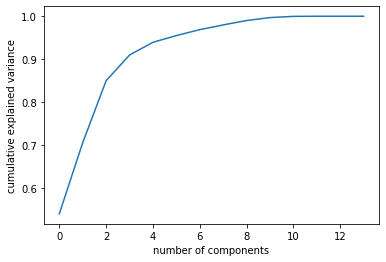

In [8]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import numpy as np

pca = PCA().fit(data_scaled)
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance');
plt.show()

Cluster.

In [9]:
import sklearn.cluster as cluster

kmeans_clustering = cluster.KMeans(n_clusters=8).fit(data_scaled)
dbscan_clustering = cluster.DBSCAN().fit(data_scaled)
spectr_clustering = cluster.SpectralClustering(random_state=0).fit(data_scaled)

In [10]:
from collections import Counter
print(Counter(kmeans_clustering.labels_))
print(Counter(dbscan_clustering.labels_))
print(Counter(spectr_clustering.labels_))

Counter({1: 186, 2: 146, 0: 90, 3: 44, 4: 30, 6: 17, 5: 15, 7: 9})
Counter({0: 181, 2: 142, 1: 86, 4: 44, 6: 27, -1: 24, 3: 13, 5: 12, 7: 8})
Counter({0: 186, 6: 146, 3: 90, 5: 44, 4: 30, 2: 17, 1: 15, 7: 9})


Text(0.5, 1.0, 'KMeans Plot on 2 Dimensions')

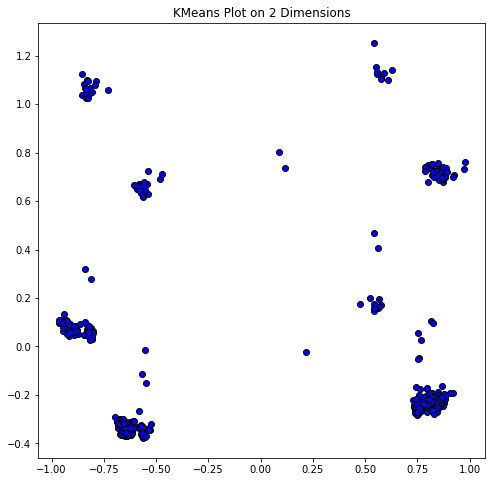

In [11]:
X = PCA(n_components=2).fit_transform(data_scaled)
plt.figure(figsize=(8, 8))
for xy in X:
    plt.plot(xy[0],
             xy[1],
             'o',
             markerfacecolor='b',
             markeredgecolor='k', 
             markersize=6)

plt.title('KMeans Plot on 2 Dimensions')


In [12]:
from sklearn import metrics

dbscan_data = data_scaled[dbscan_clustering.labels_ != -1]
dbscan_labels = dbscan_clustering.labels_[dbscan_clustering.labels_ != -1]

print(metrics.silhouette_score(data_scaled, kmeans_clustering.labels_, metric='euclidean'))
print(metrics.silhouette_score(dbscan_data, dbscan_labels, metric='euclidean'))
print(metrics.silhouette_score(data_scaled, spectr_clustering.labels_, metric='euclidean'))

0.5811330547436199
0.6087764396790916
0.5811330547436199


In [13]:
print(metrics.calinski_harabasz_score(data_scaled, kmeans_clustering.labels_))
print(metrics.calinski_harabasz_score(dbscan_data, dbscan_labels))
print(metrics.calinski_harabasz_score(data_scaled, spectr_clustering.labels_))

434.4988653160144
554.2819127244551
434.49886531601436


In [14]:
print(metrics.davies_bouldin_score(data_scaled, kmeans_clustering.labels_))
print(metrics.davies_bouldin_score(dbscan_data, dbscan_labels))
print(metrics.davies_bouldin_score(data_scaled, spectr_clustering.labels_))

0.7056668139123196
0.5794898046550441
0.7056668139123196


Visualize the clustering.

In [15]:
def plot_cluster(XY, labels, name): 
    unique_labels = set(labels)
    n_clusters = len(unique_labels)
    colors = [plt.cm.Spectral(each) for each in np.linspace(0, 1, len(unique_labels))]
    
    if any([x == -1 for x in unique_labels]):
        n_clusters = n_clusters - 1
    
    plt.figure(figsize=(9, 7))
    for k, col in zip(unique_labels, colors):
        if k == -1:
            col = [0, 0, 0, 1]

        class_member_mask = (labels == k)
        xy = XY[class_member_mask]
        plt.plot(xy[:, 0],
                 xy[:, 1],
                 'o',
                 markerfacecolor=tuple(col),
                 markeredgecolor='k', 
                 markersize=6)
    plt.title(name + ' ' + 'Estimated number of clusters: %d' % n_clusters)
    plt.show()

In [16]:
XY = PCA(n_components=2).fit_transform(data_scaled)

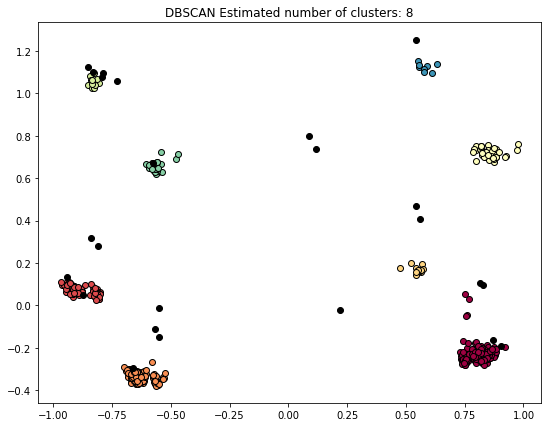

In [17]:
plot_cluster(XY, dbscan_clustering.labels_, 'DBSCAN')

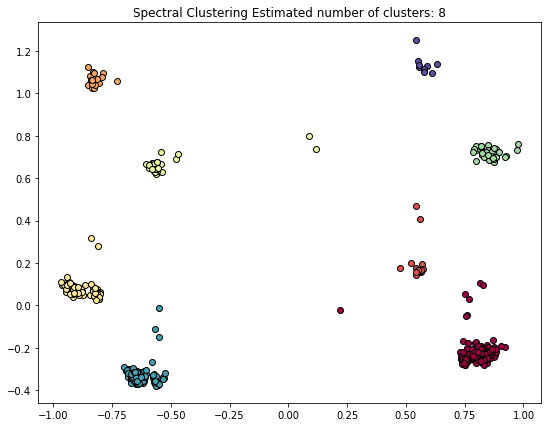

In [18]:
plot_cluster(XY, spectr_clustering.labels_, 'Spectral Clustering')

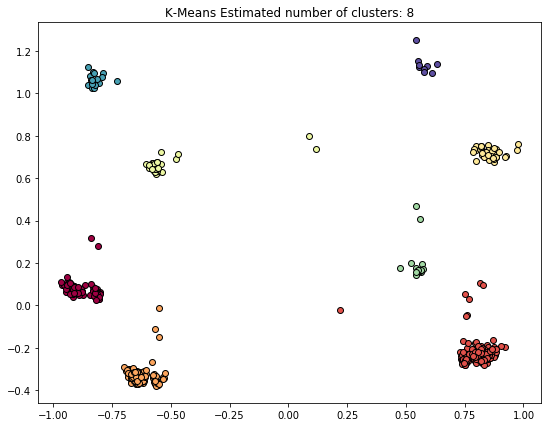

In [19]:
plot_cluster(XY, kmeans_clustering.labels_, 'K-Means')